In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

from shared_utils import rt_dates
from segment_speed_utils import helpers, wrangle_shapes
from segment_speed_utils.project_vars import SEGMENT_GCS, SHARED_GCS

analysis_date = rt_dates.DATES["oct2023"]

road_id_cols = ["linearid", "mtfcc", "primary_direction"]
segment_identifier_cols = road_id_cols + ["segment_sequence"]

two_roads = [
    "1104259334520",
    "110413812414"
]

In [2]:
df = pd.read_parquet(
    f"{SEGMENT_GCS}roads_staging/"
    f"test_speeds_{analysis_date}.parquet"
)        

In [13]:
df[(df.speed_mph >= 50) & (df.sec_elapsed >= 20)].speed_mph.describe()

count    13825.000000
mean        62.515942
std         14.945324
min         50.008048
25%         55.929349
50%         60.148924
75%         63.596422
max        325.685493
Name: speed_mph, dtype: float64

In [12]:
df[(df.speed_mph >= 50) & (df.meters_elapsed >= 1609/2)].speed_mph.describe()

count    14171.000000
mean       146.109375
std        361.584684
min         50.008048
25%         56.920457
50%         60.638919
75%         66.134505
max       4364.788886
Name: speed_mph, dtype: float64

<AxesSubplot:>

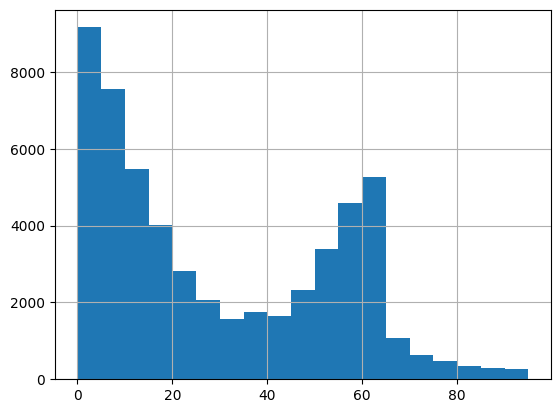

In [5]:
df.speed_mph.hist(bins=range(0, 100, 5))

In [ ]:
shape_road_crosswalk

In [ ]:
shape_road_crosswalk = pd.read_parquet(
    f"{SEGMENT_GCS}roads_staging/"
    f"shape_road_crosswalk_{analysis_date}.parquet",
    filters = [[("linearid", "in", two_roads)]]
)

In [ ]:
one_shape = "2419613ed3a3e49420a24f8d7efd3a4e"

shape_to_trip = helpers.import_scheduled_trips(
    analysis_date,
    columns = ["trip_instance_key", "shape_array_key"],
    filters = [[("shape_array_key", "==", one_shape)]]
)

one_trip = shape_to_trip.trip_instance_key[5]
one_trip

In [ ]:
shape_road_crosswalk = shape_road_crosswalk.merge(
    shape_to_trip,
    on = "shape_array_key",
    how = "inner"
)

In [ ]:
vp_nn = gpd.read_parquet(
    f"{SEGMENT_GCS}condensed/vp_nearest_neighbor_{analysis_date}.parquet",
    filters = [[("trip_instance_key", "==", one_trip)]]
)

In [ ]:
subset_shape = helpers.import_scheduled_trips(
    analysis_date,
    columns = ["trip_instance_key", "shape_array_key"],
    filters = [[("trip_instance_key", "==", one_trip)]],
    get_pandas = True
)

shapes = helpers.import_scheduled_shapes(
    analysis_date,
    columns = ["shape_array_key", "geometry"],
    filters = [[("shape_array_key", "in", subset_shape.shape_array_key)]],
    crs = "EPSG:3310"
).merge(subset_shape)

shapes = shapes.assign(
    geometry = shapes.geometry.buffer(25)
).to_crs("EPSG:4326")

In [ ]:
shapes

In [ ]:
road_segments = gpd.read_parquet(
    f"{SHARED_GCS}road_segments/",
    columns = segment_identifier_cols + ["geometry"],
    filters = [[("linearid", "in", two_roads)]]
)

In [ ]:
# We can substitute this step when we have already generated crosswalk
def sjoin_shape_to_road(shapes, roads):
  
    keep_cols = ["shape_array_key", "trip_instance_key", 
                 "linearid", 
       "mtfcc", "segment_sequence"]
    
    roads = roads.to_crs(shapes.crs)
    
    shapes_to_roads = gpd.sjoin(
        shapes,
        roads,
        how = "inner",
        predicate = "intersects"
    )[keep_cols].drop_duplicates()
    
    return shapes_to_roads

#road_segments_sjoin = sjoin_shape_to_road(shapes, road_segments)

In [ ]:
road_segments2 = pd.merge(
    road_segments,
    shape_road_crosswalk,
    on = ["linearid", "mtfcc", "segment_sequence"], 
    how = "inner"
)

In [ ]:
road_segments2

In [ ]:
import shapely

road_segments0 = road_segments2.assign(
    geometry = road_segments2.apply(
        lambda x: shapely.Point(x.geometry.coords[0]), 
        axis=1),
).assign(stop_type=0)

road_segments1 = road_segments2.assign(
    geometry = road_segments2.apply(
        lambda x: shapely.Point(x.geometry.coords[-1]), 
        axis=1),
).assign(stop_type=1)

In [ ]:
road_segments_long = pd.concat(
    [road_segments0, road_segments1], 
    axis=0
).sort_values(
    ["linearid", "segment_sequence", "stop_type"]
).rename(
    columns = {"primary_direction": "stop_primary_direction"}
).reset_index(drop=True)

In [ ]:
road_segments_long

In [ ]:
from segment_speed_utils import neighbor

gdf = neighbor.merge_stop_vp_for_nearest_neighbor(
    road_segments_long, 
    analysis_date
)

In [ ]:
results = neighbor.add_nearest_neighbor_result(gdf, analysis_date)

In [ ]:
results2 = results.copy()

In [ ]:
PROJECT_CRS = "EPSG:3310"

results2 = results2.assign(
    stop_geometry = results2.stop_geometry.to_crs(PROJECT_CRS),
    vp_coords_trio = results2.vp_coords_trio.to_crs(PROJECT_CRS)
)

In [ ]:
shapes = helpers.import_scheduled_shapes(
    analysis_date,
    columns = ["shape_array_key", "geometry"],
    crs = PROJECT_CRS
).dropna(subset="geometry")

gdf = pd.merge(
    results2,
    shapes.rename(columns = {"geometry": "shape_geometry"}),
    on = "shape_array_key",
    how = "inner"
)

In [ ]:
results2.dtypes

In [ ]:
import interpolate_stop_arrival

In [ ]:
segment_identifier_cols2 = ['linearid', 'mtfcc', 
                            'stop_primary_direction', 'segment_sequence']

In [ ]:
stop_meters_series = []
stop_arrival_series = []
for row in gdf.itertuples():

    stop_meters, interpolated_arrival = interpolate_stop_arrival.project_points_onto_shape(
        getattr(row, "stop_geometry"),
        getattr(row, "vp_coords_trio"),
        getattr(row, "shape_geometry"),
        getattr(row, "location_timestamp_local_trio")
    )

    stop_meters_series.append(stop_meters)
    stop_arrival_series.append(interpolated_arrival)

results2 = gdf.assign(
    stop_meters = stop_meters_series,
    arrival_time = stop_arrival_series,
)[segment_identifier_cols2 + [
    "trip_instance_key", "shape_array_key", 
    "stop_type",
     "stop_meters", "arrival_time"]
 ].sort_values(
    segment_identifier_cols2 + ["trip_instance_key", "stop_type", ]
).reset_index(drop=True)

In [ ]:
grouped_df = results2.groupby(segment_identifier_cols2 + 
                               ["trip_instance_key"])

min_arrival = grouped_df.agg({"arrival_time": "min"}).reset_index()
max_arrival = grouped_df.agg({"arrival_time": "max"}).reset_index()

min_max_arrival = pd.merge(
    min_arrival,
    max_arrival,
    on = segment_identifier_cols2 + ["trip_instance_key"]
).query('arrival_time_x != arrival_time_y')

In [ ]:
results3 = pd.merge(
    results2,
    min_max_arrival[segment_identifier_cols2 + ["trip_instance_key"]],
    on = segment_identifier_cols2 + ["trip_instance_key"],
    how = "inner"
)

In [ ]:
from segment_speed_utils import segment_calcs

results3 = segment_calcs.convert_timestamp_to_seconds(
    results3, ["arrival_time"]
).sort_values(segment_identifier_cols2 + ["trip_instance_key"]).reset_index(drop=True)

In [ ]:
trip_cols = segment_identifier_cols2 + ["trip_instance_key"]
results3 = results3.assign(
        subseq_arrival_time_sec = (results3.groupby(trip_cols, 
                                             observed=True, group_keys=False)
                                  .arrival_time_sec
                                  .shift(-1)
                                 ),
        subseq_stop_meters = (results3.groupby(trip_cols, 
                                        observed=True, group_keys=False)
                             .stop_meters
                             .shift(-1)
                            )
    )

In [ ]:
speed = results3.assign(
    meters_elapsed = results3.subseq_stop_meters - results3.stop_meters, 
    sec_elapsed = results3.subseq_arrival_time_sec - results3.arrival_time_sec,
).pipe(
    segment_calcs.derive_speed, 
    ("stop_meters", "subseq_stop_meters"), 
    ("arrival_time_sec", "subseq_arrival_time_sec")
)

In [ ]:
speed.dropna().query(
    'meters_elapsed > 250 & sec_elapsed > 60'
).speed_mph.describe()